In [1]:
%pip install numpy pandas mne tensorflow scikit-learn torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import mne
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 

mne.set_log_level('WARNING')

E0000 00:00:1766032507.745755      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766032507.833571      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766032508.646583      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766032508.646641      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766032508.646644      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766032508.646646      55 computation_placer.cc:177] computation placer already registered. Please check linka

In [3]:
class Config:
    DATASET_PATH = '/kaggle/input/physionet-eeg-motor-movement-imagery/files'
    RUN_ID = 1
    TARGET_CHANNELS = ['Oz', 'T7', 'Cz']
    WINDOW_SIZE = 160
    STRIDE = 4
    SAMPLE_RATE = 160
    TRAIN_SUBJECTS = range(1, 90)
    TEST_SUBJECTS = range(90, 109)


    BATCH_SIZE = 64
    EPOCHS = 10
    

In [4]:
#Data Preprocessing Part
def gram_schmidt(vectors):
    """
    Orthogonalizes channels to remove correlation (Paper Method).
    Args:
        vectors (np.array): Shape (n_samples, n_channels)
    Returns:
        np.array: Orthogonalized vectors
    """
    basis = np.zeros_like(vectors)
    for i in range(vectors.shape[1]):
        v = vectors[:, i]
        u = v.copy()
        for j in range(i):
            prev_u = basis[:, j]
            norm_prev = np.dot(prev_u, prev_u)
            if norm_prev > 1e-10:
                projection = (np.dot(v, prev_u) / norm_prev) * prev_u
                u -= projection
        basis[:, i] = u
    return basis

def create_segments(data, label, window_size, stride):
    """Slice continuous signal into training segments."""
    n_samples = data.shape[0]
    segments = []
    labels = []
    for start in range(0, n_samples - window_size + 1, stride):
        end = start + window_size
        segment = data[start:end, :]
        if segment.shape == (window_size, data.shape[1]):
            segments.append(segment)
            labels.append(label)
    return segments, labels

def load_data_for_subjects(subject_list, config):
    """Loads, orthogonalizes, and segments data for a list of subjects."""
    all_X = []
    all_y = []
    
    print(f"Loading data for {len(subject_list)} subjects...")
    
    for i, subject_id in enumerate(subject_list):
        try:
            # Construct file path
            path = f"{config.DATASET_PATH}/S{subject_id:03d}/S{subject_id:03d}R{config.RUN_ID:02d}.edf"
            if not os.path.exists(path):
                continue
                
            # Load & Resample
            raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
            if raw.info['sfreq'] != config.SAMPLE_RATE:
                raw.resample(config.SAMPLE_RATE, npad="auto", verbose=False)
            
            mne.rename_channels(raw.info, lambda x: x.strip('.'))
            try:
                raw.pick(config.TARGET_CHANNELS)
            except ValueError:
                continue
                
            data = raw.get_data().T
            
            # Apply Gram-Schmidt & Scaling
            data = gram_schmidt(data)
            scaler = MinMaxScaler(feature_range=(0, 1))
            data = scaler.fit_transform(data)
            
            # Create Segments
            X, y = create_segments(data, i, config.WINDOW_SIZE, config.STRIDE)
            
            all_X.extend(X)
            all_y.extend(y)
            
        except Exception as e:
            print(f"  Error S{subject_id}: {e}")
            
    return np.array(all_X), np.array(all_y)

In [7]:
def build_cnn_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)  # (WINDOW_SIZE, 3)

    # add channel dimension -> (WINDOW_SIZE, 3, 1)
    x = tf.keras.layers.Reshape(
        (input_shape[0], input_shape[1], 1)
    )(inputs)

    # block 1
    x = tf.keras.layers.Conv2D(32, kernel_size=(5, 2), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # block 2
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 2), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # block 3
    x = tf.keras.layers.Conv2D(128, kernel_size=(3, 2), activation="relu", padding="same")(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # fingerprint layer
    features = tf.keras.layers.Dense(
        128, activation="relu", name="fingerprint_layer"
    )(x)

    # classification head (training only)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(features)

    model = tf.keras.Model(inputs, outputs)
    return model


In [8]:
# LOADING TEH DATA AND TRAINIG

cfg = Config()
print("Phase 1: Loading Training Data (Subject 1-89)...")
X_train, y_train = load_data_for_subjects(cfg.TRAIN_SUBJECTS, cfg)

# perpare the data by splitting
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int32)

idx = np.arange(len(X_train))
np.random.shuffle(idx)
X_train, y_train = X_train[idx], y_train[idx]

Phase 1: Loading Training Data (Subject 1-89)...
Loading data for 89 subjects...


In [9]:
# Build and traing the model
model = build_cnn_model(
    (cfg.WINDOW_SIZE, 3),
    len(cfg.TRAIN_SUBJECTS)
)

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [11]:
print("\nPhase 2: Training Model ....")

history = model.fit(
    X_train, y_train,
    epochs = cfg.EPOCHS,
    batch_size=cfg.BATCH_SIZE,
    validation_split=0.1,
    verbose=1
)


Phase 2: Training Model ....
Epoch 1/10
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 176s 58ms/step - accuracy: 0.7181 - loss: 1.1097 - val_accuracy: 0.1287 - val_loss: 12.4924
Epoch 2/10
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 174s 58ms/step - accuracy: 0.9788 - loss: 0.0635 - val_accuracy: 0.9108 - val_loss: 0.2977
Epoch 3/10
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 205s 59ms/step - accuracy: 0.9901 - loss: 0.0308 - val_accuracy: 0.9198 - val_loss: 0.2615
Epoch 4/10
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 173s 57ms/step - accuracy: 0.9934 - loss: 0.0210 - val_accuracy: 0.9840 - val_loss: 0.0536
Epoch 5/10
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 201s 57ms/step - accuracy: 0.9948 - loss: 0.0171 - val_accuracy: 0.8399 - val_loss: 0.8079
Epoch 6/10
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 171s 57ms/step - accuracy: 0.9959 - loss: 0.0135 - val_accuracy: 0.6570 - val_loss: 2.3808
Epoch 7/10
3004/3004 ━━━━━━━━━━━━━━━━━━━━ 172s 57ms/step - accuracy: 0.9971 - loss: 0.0092 - val_accuracy: 0.9817 - val_loss: 0.0636
Epoch 8/10
3004/3004 ━━━━━━━━━━━━━━━━━

In [12]:
fingerprint_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer('fingerprint_layer').output
)


Phase 3: Loading Test Data...
Loading data for 19 subjects...

--- Starting Authentication Evaluation on 19 Unseen Users ---
Generating embeddings...
357/357 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step

=== FINAL RESULTS ===
AUC Score: 0.9918
EER (Equal Error Rate): 0.0426 (4.26%)
Optimal Similarity Threshold: 0.8148


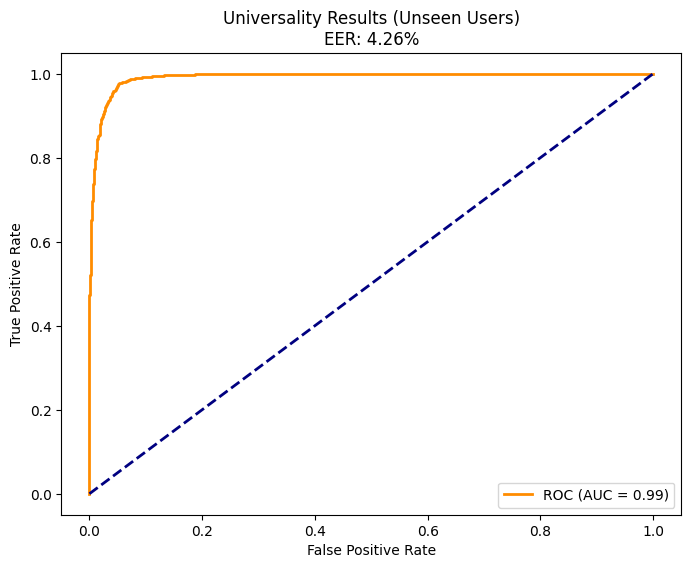

In [13]:
def evaluate_authentication(model, X_test, y_test):
    """
    Calculates ROC and EER for Universality (Unseen Users).
    """
    unique_users = np.unique(y_test)
    all_gen_scores = [] 
    all_imp_scores = []
    
    print(f"\n--- Starting Authentication Evaluation on {len(unique_users)} Unseen Users ---")
    
    # Generate Embeddings for all test data
    print("Generating embeddings...")
    embeddings = model.predict(X_test, batch_size=128, verbose=1)
    
    for user_idx in unique_users:
        user_indices = np.where(y_test == user_idx)[0]
        impostor_indices = np.where(y_test != user_idx)[0]
        
        # Split: 50% Enrollment, 50% Probe
        split_point = len(user_indices) // 2
        enroll_indices = user_indices[:split_point]
        probe_indices = user_indices[split_point:]
        
        if len(enroll_indices) == 0 or len(probe_indices) == 0:
            continue
            
        # 1. Create Template (Average of enrollment samples)
        enroll_vecs = embeddings[enroll_indices]
        template = np.mean(enroll_vecs, axis=0)
        
        # 2. Genuine Scores (Distance to own template)
        probe_vecs = embeddings[probe_indices]
        for vec in probe_vecs:
            dist = cosine(template, vec)
            all_gen_scores.append(dist)
            
        # 3. Impostor Scores (Distance to random others)
        np.random.shuffle(impostor_indices)
        sel_imp_indices = impostor_indices[:100] 
        imp_vecs = embeddings[sel_imp_indices]
        for vec in imp_vecs:
            dist = cosine(template, vec)
            all_imp_scores.append(dist)

    # --- Metrics & ROC Curve ---
    y_true = [1] * len(all_gen_scores) + [0] * len(all_imp_scores)
    # Convert Distance to Similarity (1 - Distance) for ROC
    y_scores = (1 - np.array(all_gen_scores)).tolist() + (1 - np.array(all_imp_scores)).tolist()
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Calculate Equal Error Rate (EER)
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.absolute((fnr - fpr)))
    EER = fpr[eer_idx]
    optimal_threshold = thresholds[eer_idx]
    
    print(f"\n=== FINAL RESULTS ===")
    print(f"AUC Score: {roc_auc:.4f}")
    print(f"EER (Equal Error Rate): {EER:.4f} ({EER*100:.2f}%)")
    print(f"Optimal Similarity Threshold: {optimal_threshold:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Universality Results (Unseen Users)\nEER: {EER:.2%}')
    plt.legend(loc="lower right")
    plt.show()
    
    return optimal_threshold

# Run Evaluation
print("\nPhase 3: Loading Test Data...")
X_test, y_test = load_data_for_subjects(cfg.TEST_SUBJECTS, cfg)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)

optimal_thresh = evaluate_authentication(fingerprint_model, X_test, y_test)